In [390]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_samples, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from xgboost.sklearn import XGBClassifier
import sklearn
import statsmodels
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy
import requests
import pprint
import xgboost
import scipy
import warnings
import re
from datetime import datetime
from scipy import stats
from urllib import parse
from bs4 import BeautifulSoup

# 지수 형태의 실수를 소수점 3자리까지 표기
pd.options.display.float_format = "{:.3f}".format

# 공유 폴더 경로
dirShare = ".."

# 경고 출력 무시
warnings.filterwarnings("ignore")

In [ ]:
# 라이브러리 버전 확인
print("pandas 현재 버전 : " + pd.__version__)
print("scikit-learn 현재 버전 : " + sklearn.__version__)
print("scipy 현재 버전 : "+ scipy.__version__)
print("statsmodels 현재 버전 : " + statsmodels.__version__)
print("xgboost 현재 버전 : " + xgboost.__version__)

# 데이터 불러오고 전처리

## 기본전처리

In [391]:
# train.csv 데이터 프레임으로 불러오기
df = pd.read_csv(dirShare+"/data/train.csv")

# # df 정보 확인
# df.info()

# # df 상위 10개 불러오기
# df.head(10)

In [392]:
df_t = pd.read_csv(dirShare+"/data/test.csv")

# df_t.info()
# df_t.head()

In [ ]:
# 데이터 개수 확인하기
print("train 데이터 개수 : ", df.shape[0])
print("test 데이터 개수 : ", df_t.shape[0])

# len(df)를 써도 동일

In [ ]:
# 숫자 형식의 컬럼의 기술통계값을 출력, train.csv
df.describe()

In [ ]:
# 숫자 형식의 컬럼의 기술통계값을 출력, test.csv
df_t.describe()

In [ ]:
# 컬럼별 null 값 확인하기, train.csv
df.shape[0] - df.count()

In [ ]:
# 컬럼별 null 값 확인하기, test.csv
df_t.shape[0] - df_t.count()

In [393]:
# employee 컬럼이 object 타입이고, 숫자에 ','이 포함돼 있어 정규 표현식으로 없앰
for i in range(2) : 
    df_t["employee"+str(i+1)] = df_t["employee"+str(i+1)].map(lambda x: re.sub(r"[^0-9.-]", "", str(x)))

df_t[["employee1", "employee2"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   employee1  127 non-null    object
 1   employee2  127 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [394]:
# 실수 타입으로 변경
df_t["employee1"].replace("", np.NaN, inplace=True)
df_t["employee2"].replace("", np.NaN, inplace=True)
df_t[["employee1", "employee2"]] = df_t[["employee1", "employee2"]].astype("float64")
df_t[["employee1", "employee2"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   employee1  119 non-null    float64
 1   employee2  112 non-null    float64
dtypes: float64(2)
memory usage: 2.1 KB


In [ ]:
df_t[["employee1", "employee2"]].head()

In [396]:
# train과 test를 일시적으로 합침
df_merge = pd.concat(objs=[df,df_t], axis=0)
print("합친 데이터 수 : ",len(df_merge))
df_merge.head()

합친 데이터 수 :  428


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228.000,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,same
1,3,open,gyeongnam,32,19970401.000,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,same
2,4,open,gyeonggi,89,20161228.000,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,same
3,7,open,incheon,141,20000814.000,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,same
4,9,open,gyeongnam,32,20050901.000,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,same


In [397]:
# 아직 운영 중인 병원을 1로 변환
df_merge.replace({"open":1},inplace=True)
# 폐업한 병원을 0으로 변환
df_merge.replace({" close":0}, inplace=True)
# unique() 메서드를 통해 "OC" 컬럼의 데이터를 확인
# df["OC"].unique()
df_merge.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1.000,choongnam,73,20071228.000,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,same
1,3,1.000,gyeongnam,32,19970401.000,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,same
2,4,1.000,gyeonggi,89,20161228.000,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,same
3,7,1.000,incheon,141,20000814.000,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,same
4,9,1.000,gyeongnam,32,20050901.000,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,same


In [398]:
# 오너 변환 여부
df_merge["ownerChange"].replace({"same":0},inplace=True)
df_merge["ownerChange"].replace({"change":1},inplace=True)
# df["ownerChange"].unique()
df_merge.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1.000,choongnam,73,20071228.000,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,0.000
1,3,1.000,gyeongnam,32,19970401.000,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,0.000
2,4,1.000,gyeonggi,89,20161228.000,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,0.000
3,7,1.000,incheon,141,20000814.000,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,0.000
4,9,1.000,gyeongnam,32,20050901.000,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,0.000


In [ ]:
df_merge["instkind"].unique()

In [399]:
# 영업이익 컬럼 추가(매출액 - 매출원가 - 판매 관리비 - 급여)
# revenue - salescost - sga - salary

for i in range(2) : 
    df_merge.insert(loc=(24*(i)+11), column="busiProfit"+str(i+1), value=(df_merge["revenue"+str(i+1)]-df_merge["salescost"+str(i+1)]-df_merge["sga"+str(i+1)]-df_merge["salary"+str(i+1)]))

df_merge.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1.000,choongnam,73,20071228.000,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,0.000
1,3,1.000,gyeongnam,32,19970401.000,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,0.000
2,4,1.000,gyeonggi,89,20161228.000,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,0.000
3,7,1.000,incheon,141,20000814.000,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,0.000
4,9,1.000,gyeongnam,32,20050901.000,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,0.000


In [400]:
# 병원 종류 별 병상 수의 차이
df_bed = df_merge.groupby("instkind",axis=0)["bedCount"].count()
df_bed

instkind
clinic                   22
dental_clinic             1
general_hospital         56
hospital                120
nursing_hospital        204
traditional_clinic        5
traditional_hospital      6
Name: bedCount, dtype: int64

In [ ]:
# 병원의 병상 수가 많으면 그만큼 환자 수용 수가 많으니 병원 서비스가 더 좋아지는 것이 아닐까?

plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
    
plt.bar(x=df_bed.index, height=df_bed, color="#009933")
plt.title("병원 종류별 병상 수")
plt.xlabel("병원 종류")
plt.ylabel("병상 갯수")
plt.show()

In [401]:
# 개업한 날짜는 변수로서 의미가 없음. 모델은 날짜를 인식하지 못하기 때문에
# 개업 날짜와 폐업 날짜의 차이로 변수를 조정할 필요가 있음

date_of_2018 = "2018-01-01"

# 문자 타입을 date 타입으로

# df["openDate"] = df["openDate"].apply(lambda x : datetime.strptime(str(x), "%Y%m%d")) # ValueError: unconverted data remains: .0
df_merge["openDate"] = pd.to_datetime(df_merge["openDate"], format="%Y%m%d")

# 날짜 차이를 새로운 컬럼으로 생성, 데이터 프레임 중간에 삽입
df_merge.insert(2, "dif_date", datetime.strptime(date_of_2018,"%Y-%m-%d")-df_merge["openDate"])
df_merge["dif_date"] = df_merge["dif_date"].dt.days

df_merge.drop(labels="openDate", axis=1, inplace=True)

df_merge["dif_date"].tail()
df_merge.head()

,inst_id,OC,dif_date,sido,sgg,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1.000,3657.000,choongnam,73,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,0.000
1,3,1.000,7580.000,gyeongnam,32,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,0.000
2,4,1.000,369.000,gyeonggi,89,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,0.000
3,7,1.000,6349.000,incheon,141,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,0.000
4,9,1.000,4505.000,gyeongnam,32,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,0.000


In [402]:
# 병원의 종류를, get_dummies를 이용해 one-hot-encoding
df_m = pd.get_dummies(df_merge, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)
df_m.head()

,inst_id,OC,dif_date,sido,sgg,bedCount,revenue1,salescost1,sga1,salary1,...,employee1,employee2,ownerChange,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital
0,1,1.000,3657.000,choongnam,73,175.000,4217530010.000,0.000,3961134739.000,2033835290.000,...,62.000,64.000,0.000,0,0,0,0,1,0,0
1,3,1.000,7580.000,gyeongnam,32,410.000,NaN,NaN,NaN,NaN,...,801.000,813.000,0.000,0,0,1,0,0,0,0
2,4,1.000,369.000,gyeonggi,89,468.000,1004521989.000,515483669.000,447219722.000,296402310.000,...,234.000,1.000,0.000,0,0,0,0,1,0,0
3,7,1.000,6349.000,incheon,141,353.000,72507342181.000,0.000,70677397660.000,31786048663.000,...,663.000,663.000,0.000,0,0,1,0,0,0,0
4,9,1.000,4505.000,gyeongnam,32,196.000,49043538016.000,0.000,47656051197.000,24460782270.000,...,206.000,197.000,0.000,0,0,1,0,0,0,0


In [403]:
df_m.reset_index(level=0, drop=True, inplace=True)

In [404]:
# 영어로 돼 있는 '시도'를 한글로 변환

df_m["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong', 'jeju'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시", '제주특별자치도'],inplace=True)

print("df_new의 시도 : ",df_m["sido"].unique())
df_m.head()

df_new의 시도 :  ['충청남도' '경상남도' '경기도' '인천광역시' '부산광역시' '전라남도' '서울특별시' '전라북도' '충청북도' '울산광역시'
 '대전광역시' '대구광역시' '경상북도' '강원도' '광주광역시' '세종특별자치시' '제주특별자치도']


,inst_id,OC,dif_date,sido,sgg,bedCount,revenue1,salescost1,sga1,salary1,...,employee1,employee2,ownerChange,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital
0,1,1.000,3657.000,충청남도,73,175.000,4217530010.000,0.000,3961134739.000,2033835290.000,...,62.000,64.000,0.000,0,0,0,0,1,0,0
1,3,1.000,7580.000,경상남도,32,410.000,NaN,NaN,NaN,NaN,...,801.000,813.000,0.000,0,0,1,0,0,0,0
2,4,1.000,369.000,경기도,89,468.000,1004521989.000,515483669.000,447219722.000,296402310.000,...,234.000,1.000,0.000,0,0,0,0,1,0,0
3,7,1.000,6349.000,인천광역시,141,353.000,72507342181.000,0.000,70677397660.000,31786048663.000,...,663.000,663.000,0.000,0,0,1,0,0,0,0
4,9,1.000,4505.000,경상남도,32,196.000,49043538016.000,0.000,47656051197.000,24460782270.000,...,206.000,197.000,0.000,0,0,1,0,0,0,0


## 인구 데이터 합치기

In [405]:
# 2017년 지역별 인구수 데이터
# https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3
pop = pd.read_csv(dirShare+"/data/행정구역_시군구_별__성별_인구수_20230718231833.csv", header=1, encoding="cp949")
pop.info()
pop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   행정구역(시군구)별  18 non-null     object
 1   총인구수 (명)    18 non-null     int64 
 2   남자인구수 (명)   18 non-null     int64 
 3   여자인구수 (명)   18 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 708.0+ bytes


,행정구역(시군구)별,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,51778544,25855919,25922625
1,서울특별시,9857426,4830206,5027220
2,부산광역시,3470653,1709508,1761145
3,대구광역시,2475231,1227814,1247417
4,인천광역시,2948542,1479597,1468945


In [406]:
# 컬럼명을 영어로 바꾸기
pop.rename(columns={"총인구수 (명)":"tt_pop", "남자인구수 (명)":"male_pop", "여자인구수 (명)":"female_pop"}, inplace=True)
pop.columns

Index(['행정구역(시군구)별', 'tt_pop', 'male_pop', 'female_pop'], dtype='object')

In [407]:
# df와 pop(인구수) join
df_new = pd.merge(df_m, pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
df_new.head()

,inst_id,OC,dif_date,sido,sgg,bedCount,revenue1,salescost1,sga1,salary1,...,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,행정구역(시군구)별,tt_pop,male_pop,female_pop
0,1,1.000,3657.000,충청남도,73,175.000,4217530010.000,0.000,3961134739.000,2033835290.000,...,0,0,0,1,0,0,충청남도,2116770,1076270,1040500
1,59,1.000,1385.000,충청남도,94,258.000,8546126935.000,0.000,6737509250.000,3830658980.000,...,0,0,0,1,0,0,충청남도,2116770,1076270,1040500
2,101,1.000,13026.000,충청남도,37,341.000,52626386641.000,19326736791.000,32214235859.000,20975361934.000,...,0,1,0,0,0,0,충청남도,2116770,1076270,1040500
3,134,1.000,10804.000,충청남도,78,64.000,4402779495.000,719458530.000,4131517858.000,2436024468.000,...,0,0,1,0,0,0,충청남도,2116770,1076270,1040500
4,150,1.000,1589.000,충청남도,94,186.000,5237992090.000,0.000,5060655115.000,2623322811.000,...,0,0,0,1,0,0,충청남도,2116770,1076270,1040500


In [408]:
# 시도를 one-hot-encoding
df_new = pd.get_dummies(df_new, columns=["sido"], prefix=["sido"], prefix_sep="_", dtype=int)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        428 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       427 non-null    float64
 3   sgg                            428 non-null    int64  
 4   bedCount                       415 non-null    float64
 5   revenue1                       418 non-null    float64
 6   salescost1                     418 non-null    float64
 7   sga1                           418 non-null    float64
 8   salary1                        418 non-null    float64
 9   busiProfit1                    418 non-null    float64
 10  noi1                           418 non-null    float64
 11  noe1                           418 non-null    float64
 12  interest1                      418 non-null    flo

In [409]:
# 지역을 one-hot-encoding 했으므로 시군구 컬럼은 무의미
df_new.drop(columns="행정구역(시군구)별", axis=1, inplace=True)

## statsmodels를 사용한 vif 계산

In [410]:
df_dr = df.dropna(axis=0, how="any")
df_dr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 296
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             277 non-null    int64  
 1   OC                  277 non-null    object 
 2   sido                277 non-null    object 
 3   sgg                 277 non-null    int64  
 4   openDate            277 non-null    int64  
 5   bedCount            277 non-null    float64
 6   instkind            277 non-null    object 
 7   revenue1            277 non-null    float64
 8   salescost1          277 non-null    float64
 9   sga1                277 non-null    float64
 10  salary1             277 non-null    float64
 11  noi1                277 non-null    float64
 12  noe1                277 non-null    float64
 13  interest1           277 non-null    float64
 14  ctax1               277 non-null    float64
 15  profit1             277 non-null    float64
 16  liquidAsset1 

In [411]:
df_dr.replace({"open":1},inplace=True)
# 폐업한 병원을 0으로 변환
df_dr.replace({" close":0}, inplace=True)

In [412]:
df_dr2 = pd.DataFrame()

for i in range(df_dr.shape[1]) : 
    if type(df_dr.iloc[0,i])!=str : 
        df_dr2[df_dr.columns[i]] = df_dr.iloc[:,i]

df_dr2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 296
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             277 non-null    int64  
 1   OC                  277 non-null    int64  
 2   sgg                 277 non-null    int64  
 3   openDate            277 non-null    int64  
 4   bedCount            277 non-null    float64
 5   revenue1            277 non-null    float64
 6   salescost1          277 non-null    float64
 7   sga1                277 non-null    float64
 8   salary1             277 non-null    float64
 9   noi1                277 non-null    float64
 10  noe1                277 non-null    float64
 11  interest1           277 non-null    float64
 12  ctax1               277 non-null    float64
 13  profit1             277 non-null    float64
 14  liquidAsset1        277 non-null    float64
 15  quickAsset1         277 non-null    float64
 16  receivableS1 

In [413]:
# 병원 개/폐업 정보의 다중 회귀 분석과 검정 통계량 확인
Models1 = sm.ols("OC ~ " + "+".join(df_dr2.columns[2:]), data=df_dr2.iloc[:,1:])
result1 = Models1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     OC   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     1.694
Date:                Wed, 02 Aug 2023   Prob (F-statistic):            0.00505
Time:                        22:47:47   Log-Likelihood:                 164.91
No. Observations:                 277   AIC:                            -225.8
Df Residuals:                     225   BIC:                            -37.38
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.2660      2

In [414]:
# 독립변수 X와 종속변수 y로 분리
X = df_dr2.iloc[:,2:]
y = df_dr2.iloc[:,1]

In [415]:
# 독립변수들간 다중 공선성 확인, vif 지수 10 이상이면 변수 제거 고려
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.184,sgg
1,2.367,bedCount
2,6.352,receivableS2
3,6.452,openDate
4,6.494,receivableS1
5,12.323,shortLoan2
6,15.360,shortLoan1
7,20.180,OnonCAsset2
8,20.443,OnonCAsset1
9,23.032,interest1


In [416]:
# vif 지수가 10미만인 컬럼명
vif[vif["VIF Factor"]<10.0]["features"]

0             sgg
1        bedCount
2    receivableS2
3        openDate
4    receivableS1
Name: features, dtype: object

In [417]:
feat_vif = vif[vif["VIF Factor"]<10.0]["features"]

fvList = [feat_vif[f] for f in range(len(feat_vif))]

In [418]:
fvList.insert(0, "OC")

In [419]:
df_drop_vif = df_dr[fvList]
df_drop_vif.head()

,OC,sgg,bedCount,receivableS2,openDate,receivableS1
0,1,73,175.000,523702570.000,20071228,470055740.000
2,1,89,468.000,0.000,20161228,8095950.000
3,1,141,353.000,0.000,20000814,0.000
4,1,32,196.000,3365226859.000,20050901,4099320115.000
5,1,155,243.000,197616292.000,20020501,663481970.000


In [ ]:
df_drop_vif.info()

In [420]:
Models2 = sm.ols("OC ~ " + "+".join(df_drop_vif.columns[1:]), data=df_drop_vif)
result2 = Models2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                     OC   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.144
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.337
Time:                        22:48:15   Log-Likelihood:                 122.81
No. Observations:                 277   AIC:                            -233.6
Df Residuals:                     271   BIC:                            -211.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.6489      2.209      1.652   

In [ ]:
"""
vif 지수가 10 이상이라고 무조건 제거하면 안 됨!
"""

## 일부 컬럼을 추출해 차원 축소

![EVA논문 일부1](../data/EVA논문1_1.png)  
![EVA논문 일부2](../data/EVA논문1_2.png)  

이익잉여금은 기업의 경상적인 영업활동, 고정자산의 처분, 그 밖의 자산의 처분 및 기타 임시적인 손익거래에서 생긴 결과로서 주주에게 배당금으로 지급하거나 자본으로 대체되지 않고 남아있는 부분을 말한다. 이익잉여금은 기업의 경영활동에 의한 손익거래에 의하여 발생하는 이익을 원천으로 하는 잉여금을 의미한다. 이익잉여금은 이익준비금, 기타 법정적립금, 임의적립금, 당기말 미처분이익잉여금 또는 당기말 미처리결손금의 4가지로 크게 구분된다. 총자산에서 부채와 자본금을 공제한 잔액을 잉여금이라 하는데, 이익잉여금은 이익적립금ㆍ임의적립금(자산재평가적립금 제외) 또는 당기말 미처분이익잉여금과 같이 영업거래에서 발생하는 이익의 유보를 말하는 것으로 자본거래에서 나타나는(주식의 발행차금ㆍ감자차익ㆍ합병차익) 자본잉여금과는 다르다.  
출처 : https://txsi.hometax.go.kr/docs/customer/dictionary/view.jsp?word=&word_id=7243  

자기자본(Owners' Equity, Owner's Capital)
기업의 총자본에서 차입자본금(부채)를 뺀 금액으로, 미래 일정 시점에 상환해야 할 의무가 없는 기업 고유의 재산이다. 소유주에게 귀속되어야 할 몫을 나타내기 때문에 소유주지분 또는 주주지분이라고도 불린다. 회사의 설립 때 납입된 자본과 영업활동을 하면서 벌어들인 이익 등으로 구성된다. 자기자본은 구체적 구성항목은 자본금ㆍ자본잉여금ㆍ주식발행초과금ㆍ기타포괄손익누계액ㆍ이익잉여금이며, 여기서의 자본금은 주주들이 현금이나 기타자산으로 직접 투자한 자본 중 주식의 액면가액에 해당되는 금액을 의미하며 납입자본(contributed capital)이라 불리기도 한다.  
출처 : https://www.moef.go.kr/sisa/dictionary/detail?idx=2098  

EVA는 기업의 고유한 영업호라동을 통해 창출된 순가치의 증가분으로, 세후 영업이익에서 투하 자본에 대한 자본 비용이 공제된 잔여이익
EVA = 세후순영업이익 - 자본비용  
    = (영업관련 경상이익-법인세) - (타인자본비용+자기자본비용)

In [421]:
def same_prepro(dataframe=None, df_pop=None) : 
    """
    가장 기본이 되는 데이터프레임에서
    새로운 데이터프레임을 만들 때
    그 이후 전처리를 수행하는 함수입니다.

    일부 추출한 데이터 프레임 : dataframe
    join할 인구 수 데이터 프레임 : df_pop
    """

    dataframe = pd.get_dummies(dataframe, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)
    dataframe["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong', 'jeju'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시", '제주특별자치도'],inplace=True)
    dataframe = pd.merge(dataframe, df_pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
    dataframe = pd.get_dummies(dataframe, columns=["sido"], prefix=["sido"], prefix_sep="_", dtype=int)
    dataframe.drop(columns="행정구역(시군구)별", axis=1, inplace=True)

    return dataframe
    


In [423]:
df_clst = df_merge[["inst_id","OC", "dif_date","bedCount","busiProfit1", "busiProfit2", "profit1", "surplus1", "profit2", "surplus2", 
                  "employee1", "employee2","instkind", "sido"]]

df_clst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 0 to 126
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   inst_id      428 non-null    int64  
 1   OC           301 non-null    float64
 2   dif_date     427 non-null    float64
 3   bedCount     415 non-null    float64
 4   busiProfit1  418 non-null    float64
 5   busiProfit2  418 non-null    float64
 6   profit1      418 non-null    float64
 7   surplus1     418 non-null    float64
 8   profit2      418 non-null    float64
 9   surplus2     418 non-null    float64
 10  employee1    410 non-null    float64
 11  employee2    400 non-null    float64
 12  instkind     425 non-null    object 
 13  sido         428 non-null    object 
dtypes: float64(11), int64(1), object(2)
memory usage: 50.2+ KB


In [424]:
df_clst = same_prepro(df_clst, df_pop=pop)
df_clst.info()
df_clst.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        428 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       427 non-null    float64
 3   bedCount                       415 non-null    float64
 4   busiProfit1                    418 non-null    float64
 5   busiProfit2                    418 non-null    float64
 6   profit1                        418 non-null    float64
 7   surplus1                       418 non-null    float64
 8   profit2                        418 non-null    float64
 9   surplus2                       418 non-null    float64
 10  employee1                      410 non-null    float64
 11  employee2                      400 non-null    float64
 12  instkind_clinic                428 non-null    int

,inst_id,OC,dif_date,bedCount,busiProfit1,busiProfit2,profit1,surplus1,profit2,surplus2,...,sido_부산광역시,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_제주특별자치도,sido_충청남도,sido_충청북도
0,1,1.000,3657.000,175.000,-1777440019.000,-1823360922.000,225169678.000,1496394171.000,207829685.000,1271224493.000,...,0,0,0,0,0,0,0,0,1,0
1,59,1.000,1385.000,258.000,-2022041295.000,-2800755229.000,1275195086.000,6505224190.000,881527575.000,6505224190.000,...,0,0,0,0,0,0,0,0,1,0
2,101,1.000,13026.000,341.000,-19889947943.000,-17168763568.000,61707470.000,3640579089.000,710276478.000,3615243819.000,...,0,0,0,0,0,0,0,0,1,0
3,134,1.000,10804.000,64.000,-2884221361.000,-2869957694.000,-432536136.000,0.000,-514252779.000,0.000,...,0,0,0,0,0,0,0,0,1,0
4,150,1.000,1589.000,186.000,-2445985836.000,-2023864529.000,135866817.000,0.000,264049943.000,0.000,...,0,0,0,0,0,0,0,0,1,0


In [425]:
# NaN 값이 없는 컬럼만 남기고, 지역 데이터 없애기
df_kmeans = df_clst.dropna(axis=1, how="any")
df_kmeans = df_kmeans.iloc[:, :11]
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   inst_id                        428 non-null    int64
 1   instkind_clinic                428 non-null    int32
 2   instkind_dental_clinic         428 non-null    int32
 3   instkind_general_hospital      428 non-null    int32
 4   instkind_hospital              428 non-null    int32
 5   instkind_nursing_hospital      428 non-null    int32
 6   instkind_traditional_clinic    428 non-null    int32
 7   instkind_traditional_hospital  428 non-null    int32
 8   tt_pop                         428 non-null    int64
 9   male_pop                       428 non-null    int64
 10  female_pop                     428 non-null    int64
dtypes: int32(7), int64(4)
memory usage: 25.2 KB


## kmeans를 통한 병원 세그먼트 군집

In [426]:
def visualize_silhouette(cluster_lists, X_features): 

    """
    함수 출처 : https://dev-ryuon.tistory.com/83
    """

    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=100)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [427]:
scaler1 = MinMaxScaler()

df_mmsc = df_kmeans.drop(columns=["inst_id"])

scalerX1 = scaler1.fit(df_mmsc)

X_mmsc1 = scaler1.transform(df_mmsc)

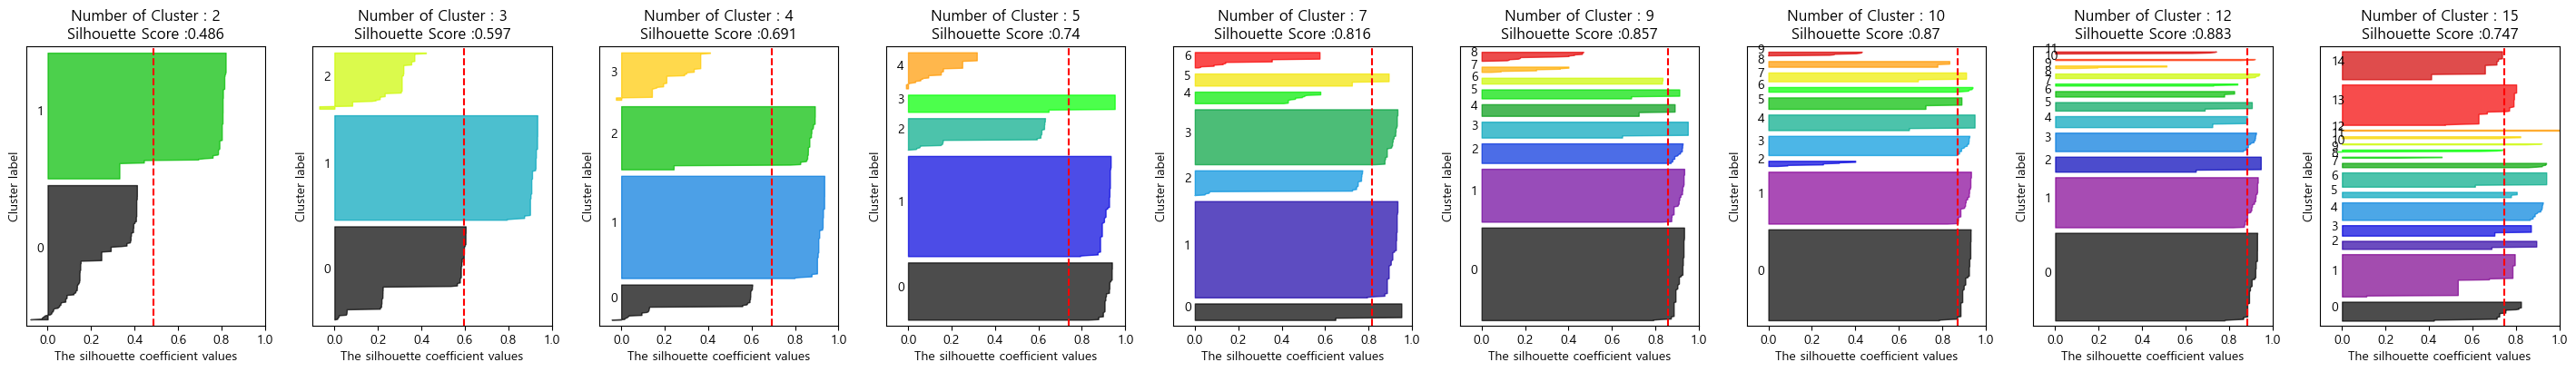

In [428]:
visualize_silhouette([2,3,4,5,7,9,10,12,15], X_mmsc1)
# 12개가 됐을 때 실루엣 계수가 0.883으로 최대

In [429]:
clst_kmeans = KMeans(n_clusters=12, random_state=100, max_iter=500)

model = clst_kmeans.fit(X_mmsc1)
clst_label = model.labels_

print(clst_label)

[ 0  0  3  1  0  0  0 10  0  1  0  8  8  0  0  0  0  0  0  0  0  8  1  0
  3  0  0  0  0  0  3  3  3  3  0  0  1  3  1  1  0  0  0  1  0  0  0  1
  1  0  0  0  3  0  0  0  0  0  1  0  1  0  0  1  0  1  1  1  0  1  1  0
  0  1  0  1  2  5  5  5  9  2  2  4  4  6  4  4  2  2  4  6  2  4  2  2
  2  6  2  2  2  9  4  2  7  4  5  5  6  5  4  2  4  9  6  7  2  2  4  5
  5  5  4  2  2  5  5  4  9  5  2  2  2  5  2  2  2  6  2  4  9  2  7  4
  3  1  3  3  1  0  1  0  0  1  3  8  1  8  3  0  0  0  0  0  0  0  0 11
  0  0  3  1  0  0  0  1  0  0  0  1  0  8 10  1  3  3  3  1  0  1  0  1
  0  0  0  0  1  0  0  0  0  0  0  0  3  1  1  1  0  0  0  1  0  0  1  0
  0  0  0  3  1  0  3  1  0  3  0  1  3 10  5  5  5  4  2  7  4  4  9  6
  5  4  6  6  4  6  6  4  7  4  6  2  2  4  5  2  2  0  0  0 11  0  0  3
  0  0  0  1  0  1  8  0  1  0  3  3  3  0  1  1  0  0  1  1  0  0  0  0
  0  1  0  0  1  0  1  0  0  0  0  0  0  1  3  0  1  0  0  0  1  3  3  0
  1  0  1  1  3  0  0  0  1  1  0  0  0  1  0  8 11

In [430]:
df_kmeans["NumberOfCluster"] = pd.Series(clst_label)
df_kmeans.tail()

,inst_id,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,tt_pop,male_pop,female_pop,NumberOfCluster
423,355,0,0,0,0,1,0,0,280100,139734,140366,0
424,207,0,0,0,0,1,0,0,280100,139734,140366,0
425,5,0,0,0,1,0,0,0,657083,330823,326260,1
426,398,0,0,0,0,1,0,0,657083,330823,326260,0
427,430,0,0,0,0,0,0,0,657083,330823,326260,11


In [ ]:
# df_kmeans.head()

In [431]:
df_kmeans.groupby(by="NumberOfCluster", axis=0)["inst_id"].count()

NumberOfCluster
0     176
1     101
2      31
3      38
4      23
5      18
6      12
7       5
8      10
9       6
10      3
11      5
Name: inst_id, dtype: int64

In [432]:
# 재무 정보가 포함돼 있는 데이터 프레임에 클러스터링 넘버 삽입
df_join_clst = pd.merge(df_clst, df_kmeans[["inst_id", "NumberOfCluster"]], how="left", left_on="inst_id", right_on="inst_id")
df_join_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        428 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       427 non-null    float64
 3   bedCount                       415 non-null    float64
 4   busiProfit1                    418 non-null    float64
 5   busiProfit2                    418 non-null    float64
 6   profit1                        418 non-null    float64
 7   surplus1                       418 non-null    float64
 8   profit2                        418 non-null    float64
 9   surplus2                       418 non-null    float64
 10  employee1                      410 non-null    float64
 11  employee2                      400 non-null    float64
 12  instkind_clinic                428 non-null    int

In [ ]:
df_join_clst[df_join_clst.isna().any(axis=1)]

In [ ]:
# df_join_clst[df_join_clst.notnull().all(axis=1)].groupby("NumberOfCluster", axis=0).max()
df_join_clst.groupby("NumberOfCluster", axis=0).min()


In [ ]:
df_clst_median = df_join_clst.groupby("NumberOfCluster", axis=0).median()
df_clst_median

In [433]:
# 군집별 히스토그램 확인

def sp_hist(DF=None, colClst=None, colhist=None, Range=None) :
    """
    군집별 특정 컬럼의 히스토그램을 확인합니다.

    DF : 히스토그램을 확인하고자 하는 데이터프레임
    colClst : 군집 번호를 표시하는 컬럼
    colhist : 히스토그램으로 표현하고자 하는 컬럼
    """
    
    fig, axs = plt.subplots(figsize=(16, 32), nrows=4, ncols=3)
    # axs는 numpy ndarray 형식

    # 한글 폰트 설정 및 깨짐 방지
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    for c in range(Range):
        dataframe = DF[DF[colClst]==c][colhist]
        # print("현재 순서 :",c)
        # print("행 :", c//3)
        # print("열 :", c%3)
        axs[(c//3),(c % 3)].hist(dataframe, bins=20)
        axs[(c//3),(c % 3)].set_title('Number of Cluster : '+ str(c)+'\n' \
                            'Column Name :' + str(dataframe.name) )
        axs[(c//3),(c % 3)].set_xlabel("계급")
        axs[(c//3),(c % 3)].set_ylabel("도수")

    plt.show()

    return

In [434]:
# 군집별 boxplot 확인
def sp_boxplot(DF=None, colClst=None, colbox=None, Range=None) :
    plt.figure(figsize=(28,20))
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False

    # rectangular box plot
    DF_box = pd.DataFrame()

    for c in range(Range) : 
        dataframe = DF[DF[colClst]==c][colbox]
        dataframe.rename(str(c), inplace=True)
        DF_box = pd.concat([DF_box, dataframe], axis=1)

    sns.boxplot(
                data = DF_box,
                orient='v'
                ) 
    plt.title("클러스터 별 boxplot")

    plt.show()
    return

In [ ]:
# 17년도 당기순이익 히스토그램
sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="profit1", Range=12)

In [ ]:
#17년도 당기순이익 박스플롯
sp_boxplot(DF=df_join_clst, colClst="NumberOfCluster", colbox="profit1", Range=10)

In [ ]:
# test_df[test_df["1"].notnull()]

In [ ]:
# 16년도 당기순이익
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="profit2")

In [ ]:
# 17년도 이익 잉여금
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="surplus1")

In [ ]:
# 16년도 이익 잉여금
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="surplus2")

In [ ]:
# 17년도 직원수
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="employee1")

In [ ]:
# 16년도 직원수
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="employee2")

- 당기순이익 : 중앙값
- 이익잉여금 : 중앙값
- 직원 수 : 16년도와 17년도의 중앙값

In [435]:
# 군집별 중앙값으로 결측치 채움

def fill_median(DF=None, colClst=None, colFill=None, numclst=None) :
    """
    결측치가 있는 행 데이터에, 군집별 중앙값을 채워 넣고자 함

    DF : 히스토그램을 확인하고자 하는 데이터프레임
    colClst : 군집 번호를 표시하는 컬럼(str)
    colFill : 결측치를 채우고자 하는 컬럼 리스트(list)
    numclst : 클러스터 개수(int)
    """
    for cl in range(numclst) :
        for L in colFill :
            median_value = DF.loc[DF[colClst] == cl, L].median()
            DF.loc[(DF[colClst] == cl) & DF[L].isnull(), L] = median_value

    return DF

In [436]:
df_join_clst = fill_median(DF=df_join_clst, colClst="NumberOfCluster", 
                           colFill=["dif_date", "bedCount","busiProfit1","busiProfit2","profit1", \
                                    "profit2", "surplus1", "surplus2", "employee1", "employee2"], numclst=12)
df_join_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        428 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       428 non-null    float64
 3   bedCount                       428 non-null    float64
 4   busiProfit1                    428 non-null    float64
 5   busiProfit2                    428 non-null    float64
 6   profit1                        428 non-null    float64
 7   surplus1                       428 non-null    float64
 8   profit2                        428 non-null    float64
 9   surplus2                       428 non-null    float64
 10  employee1                      428 non-null    float64
 11  employee2                      428 non-null    float64
 12  instkind_clinic                428 non-null    int

## SVD를 위한 작업

데이터의 양은 독립변수 수의 3배 이상은 돼야 함.
독립변수로 작용하는 컬럼 수가 57개이므로 다중 공선성과 과적합, 차원의 저주의 영향이 예상되므로
차원 축소 필요  
  
여러 특성들로 구성된 다차원의 데이터 셋의 차원을 축소해 새로운 차원의 데이터 세트를 생성  

In [437]:
# 독립변수 컬럼 샤피로 윌크 검정으로 정규성 확인
# H0 : 변수는 정규성을 따른다.
# H1 : 변수는 정규성을 따르지 않는다.

cnt = 0

for i in range(df_join_clst.shape[1]) : 
    cnt += 1
    shapiro_tt = stats.shapiro(df_join_clst.iloc[:,i])
    print(cnt)
    if shapiro_tt[1] > 0.05 : 
        print("유의수준 5%에서")
        print("컬럼명 ",df_join_clst.columns[i],"는(은) 귀무가설을 채택, 정규성을 따른다고 가정할 수 있습니다.")
    else : 
        print("유의수준 5%에서")
        print("컬럼명 ",df_join_clst.columns[i],"는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.")
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")

1
유의수준 5%에서
컬럼명  inst_id 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2
유의수준 5%에서
컬럼명  OC 는(은) 귀무가설을 채택, 정규성을 따른다고 가정할 수 있습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
3
유의수준 5%에서
컬럼명  dif_date 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
4
유의수준 5%에서
컬럼명  bedCount 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
5
유의수준 5%에서
컬럼명  busiProfit1 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
6
유의수준 5%에서
컬럼명  busiProfit2 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
7
유의수준 5%에서
컬럼명  profit1 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
8
유의수준 5%에서
컬럼명  surplus1 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
9
유의수준 5%에서
컬럼명  profit2 는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.
-*-*-*-*-*-*-*-*-*-*

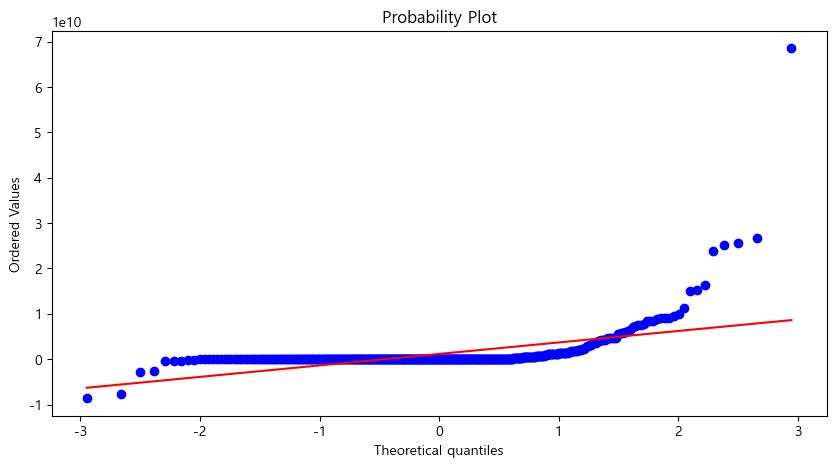

In [438]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    # 그래프 사이즈 지정
stats.probplot(df_join_clst.iloc[:,9], dist=stats.norm, plot=plt) #Sample은 어느 정도 어긋났는지 비교할 분포,
                                                  #dist는 기준이 되는 분포, 정규 분포가 아니어도 된다.
                                                  #plot은 주로 matplotlib.plt 객체 사용
plt.show()

SVD를 통해, A라는 임의의 행렬을 여러개의 A 행렬과 동일한 크기를 갖는 여러개의 행렬로 분해해서 생각할 수 있는데, 분해된 각 행렬의 원소의 값의 크기는 σ의 값의 크기에 의해 결정된다.  
다시 말해, SVD를 이용해 임의의 행렬 A를 정보량에 따라 여러 layer로 쪼개서 생각할 수 있게 해준다.  
데이터 세트가 스케일링으로 데이터 중심이 동일해지면 사이킷런의 SVD와 PCA는 동일한 변환을 수행하며, 희소 행렬(Sparse Matrix)에 대한 변환도 가능

In [439]:
# test 데이터의 inst_id가 같은 데이터만 추출
df_dvd_test = pd.merge(left=df_join_clst, right=df_t["inst_id"], how="inner", on="inst_id")
df_dvd_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        127 non-null    int64  
 1   OC                             0 non-null      float64
 2   dif_date                       127 non-null    float64
 3   bedCount                       127 non-null    float64
 4   busiProfit1                    127 non-null    float64
 5   busiProfit2                    127 non-null    float64
 6   profit1                        127 non-null    float64
 7   surplus1                       127 non-null    float64
 8   profit2                        127 non-null    float64
 9   surplus2                       127 non-null    float64
 10  employee1                      127 non-null    float64
 11  employee2                      127 non-null    float64
 12  instkind_clinic                127 non-null    int

In [440]:
# test 데이터의 inst_id가 다른 데이터만 추출 >> train 데이터
# indicator=True는 merge된 각 행의 정보를 알려줌
# left에만 존재하는 행이라면 left_only
# right에만 존재하는 행이라면 right_only
# 둘 다 존재하면 both
df_dvd_train = pd.merge(left=df_join_clst, right=df_t["inst_id"], how="outer", on="inst_id", indicator=True)
df_dvd_train = df_dvd_train[df_dvd_train["_merge"]=="left_only"].iloc[:,:df_dvd_train.shape[1]-1]
df_dvd_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 423
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        301 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       301 non-null    float64
 3   bedCount                       301 non-null    float64
 4   busiProfit1                    301 non-null    float64
 5   busiProfit2                    301 non-null    float64
 6   profit1                        301 non-null    float64
 7   surplus1                       301 non-null    float64
 8   profit2                        301 non-null    float64
 9   surplus2                       301 non-null    float64
 10  employee1                      301 non-null    float64
 11  employee2                      301 non-null    float64
 12  instkind_clinic                301 non-null    int32  


In [441]:
df_join_clst = pd.concat([df_dvd_train, df_dvd_test], axis=0)
df_join_clst.iloc[301:310, :]

,inst_id,OC,dif_date,bedCount,busiProfit1,busiProfit2,profit1,surplus1,profit2,surplus2,...,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_제주특별자치도,sido_충청남도,sido_충청북도,NumberOfCluster
0,167,NaN,3296.000,190.000,-2679160450.000,-2738795101.000,177723034.000,0.000,164882160.000,0.000,...,0,0,0,0,0,0,0,1,0,0
1,206,NaN,7915.000,339.000,-33465007645.000,-26748033398.000,11208159317.000,34114713245.000,11303536389.000,25142083421.000,...,0,0,0,0,0,0,0,1,0,3
2,213,NaN,4114.000,86.000,-1086585119.000,-1124618425.000,61977837.000,0.000,66786924.000,0.000,...,0,0,0,0,0,0,0,1,0,0
3,294,NaN,3762.000,124.000,-1206405281.000,-1317281616.000,122712741.000,0.000,-42332310.000,0.000,...,0,0,0,0,0,0,0,1,0,0
4,348,NaN,2464.000,162.000,-1746673894.000,-1597028449.000,54932529.000,0.000,59725585.000,0.000,...,0,0,0,0,0,0,0,1,0,0
5,403,NaN,1467.000,148.000,-1993093367.000,-1953488688.000,-76372463.000,0.000,-130086715.000,0.000,...,0,0,0,0,0,0,0,1,0,0
6,404,NaN,2289.000,149.000,-894151821.000,-670293289.000,41436658.000,0.000,42185031.000,0.000,...,0,0,0,0,0,0,0,1,0,0
7,88,NaN,3556.000,187.000,-4870080470.000,-4460228116.000,147691324.000,0.000,186853888.000,0.000,...,0,0,0,0,0,0,0,0,0,1
8,121,NaN,3001.000,59.000,-2998864765.000,-2767693549.000,-267732218.000,606276675.000,-66959869.000,606276675.000,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_join_clst[df_join_clst["OC"].isnull()]

In [ ]:
df_join_clst.iloc[:,-37:-1]

In [442]:
scaler2 = MinMaxScaler()

scalerX2 = scaler2.fit(df_join_clst.iloc[:,-37:-1])

X_mmsc2 = scaler2.transform(df_join_clst.iloc[:,-37:-1])

X_mmsc2

array([[0.22697795, 0.86820533, 0.83776457, ..., 0.        , 1.        ,
        0.        ],
       [0.33463035, 0.86540568, 0.82666881, ..., 0.        , 1.        ,
        0.        ],
       [0.44228275, 0.66089384, 0.6635577 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.05706874, 0.72421503, 0.63005386, ..., 1.        , 0.        ,
        0.        ],
       [0.01686122, 0.87044337, 0.84469862, ..., 1.        , 0.        ,
        0.        ],
       [0.08300908, 0.90136396, 0.86937012, ..., 1.        , 0.        ,
        0.        ]])

In [443]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# 차원 축소를 위한 SVD 수행
svd = TruncatedSVD(n_components=10)
make_svd = svd.fit(X_mmsc2)
X_svd = svd.transform(X_mmsc2)
X_svd

array([[ 1.52618538e+00, -7.30253965e-01,  2.72111167e-01, ...,
         9.22712041e-02, -5.28232808e-01, -4.60286942e-01],
       [ 1.56594124e+00, -7.36576064e-01,  2.64341865e-01, ...,
         6.94720201e-02, -5.26959958e-01, -4.57357381e-01],
       [ 1.14372991e+00, -1.76874813e-02, -1.62755925e-01, ...,
         2.35712192e-03, -5.71078712e-01, -5.53923065e-01],
       ...,
       [ 1.01879265e+00,  1.14565174e-03, -9.47077597e-01, ...,
        -1.44421577e-01, -3.51715299e-02, -1.98819908e-02],
       [ 1.38887376e+00, -7.69425725e-01,  1.80222126e-01, ...,
        -1.71748772e-02, -1.78163949e-02,  2.34601216e-02],
       [ 1.14275799e+00, -2.41468775e-01, -3.26230727e-01, ...,
         9.66964947e-02, -4.15942858e-02, -6.71096426e-02]])

# 모델학습

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=626, stratify=y)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [ ]:
df_t.shape[0]

In [ ]:
X_svd.shape

In [ ]:
print(X_svd.shape[0]-df_t.shape[0])

보통 모델의 학습용 데이터와 테스트 데이터를 'train_test_split' 메서드를 통해 분리합니다.  
데이터를 무작위로 분리하고 종속 변수의 수가 일정하지 않을 때 종속 변수 비율에 맞춰서 분리해 주기 때문입니다.🫡  
하지만 우리는 처음부터 train.csv와 test.csv로 나눠져 있었기 때문에  
처음 그대로 나눠야 합니다!⌨️

In [444]:
X_train_origin = X_svd[:301]
X_test_origin = X_svd[301:]
print("학습용 독립변수의 shape : ",X_train_origin.shape)
print("테스트 독립변수의 shape : ",X_test_origin.shape)

학습용 독립변수의 shape :  (301, 10)
테스트 독립변수의 shape :  (127, 10)


In [445]:
y_train_origin = df_join_clst.iloc[:301,1]
y_test_origin = df_join_clst.iloc[301:,1]
print("학습용 종속변수의 shape : ",y_train_origin.shape)
print("테스트 종속변수의 shape : ",y_test_origin.shape)

학습용 종속변수의 shape :  (301,)
테스트 종속변수의 shape :  (127,)


In [446]:
X_train, X_test, y_train, y_test = train_test_split(X_train_origin, y_train_origin, test_size=0.3,random_state=100, stratify=y_train_origin)
print("train 독립변수 크기 : ", X_train.shape)
print("test 독립변수 크기 : ", X_test.shape)
print("train 종속변수 크기 : ", y_train.shape)
print("test 종속변수 크기 : ", y_test.shape)

train 독립변수 크기 :  (210, 10)
test 독립변수 크기 :  (91, 10)
train 종속변수 크기 :  (210,)
test 종속변수 크기 :  (91,)


In [447]:
model_xgb = XGBClassifier()
xgb_model = model_xgb.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
# y_pred_prob = xgb_model.predict_proba(X_test)[:1]
print("정확도 : ",accuracy_score(y_test, y_pred))
print("f1 socre : ",f1_score(y_test, y_pred))

정확도 :  0.945054945054945
f1 socre :  0.9717514124293786


In [467]:
model_xgb_r = XGBClassifier(n_estimators=50,
                            max_depth = 6,
                            grow_policy='lossguide',
                            learning_rate=0.5,
                            min_child_weight=1,
                            reg_lambda=1)
xgb_model_r = model_xgb_r.fit(X_train, y_train)

y_pred_r = xgb_model_r.predict(X_test)
# y_pred_prob = xgb_model.predict_proba(X_test)[:1]
print("정확도 : ",accuracy_score(y_test, y_pred_r))
print("f1 socre : ",f1_score(y_test, y_pred_r))

정확도 :  0.945054945054945
f1 socre :  0.9717514124293786


In [448]:
X2 = df_drop_vif.iloc[:,1:]
y2 = df_drop_vif.iloc[:,0]

X_train2, X_test2, y_train2, y_test2= train_test_split(X2, y2, test_size=0.3, random_state=100, stratify=y2)
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

model_xgb2 = XGBClassifier()
xgb_model2 = model_xgb2.fit(X_train2, y_train2)

y_pred2 = xgb_model2.predict(X_test2)
y_pred_prob2 = xgb_model2.predict_proba(X_test2)[:1]

print("정확도 : ",accuracy_score(y_test2, y_pred2))
print("f1 socre : ",f1_score(y_test2, y_pred2))

(193, 5)
(84, 5)
(193,)
(84,)
정확도 :  0.9761904761904762
f1 socre :  0.9879518072289156


In [449]:
X3 = df_dr2.iloc[:,2:]
y3 = df_dr2.iloc[:,1]
# print(y_train_red)
# print(y_train_red.shape)

In [450]:
X_train3, X_test3, y_train3, y_test3= train_test_split(X3, y3, test_size=0.3, random_state=100, stratify=y3)
print(X_train3.shape)
print(X_test3.shape)
print(y_train3.shape)
print(y_test3.shape)

model_xgb_svd = XGBClassifier()
xgb_model_svd = model_xgb_svd.fit(X_train3, y_train3)

y_pred3 = xgb_model_svd.predict(X_test3)

print("정확도 : ",accuracy_score(y_test3, y_pred3))
print("f1 socre : ",f1_score(y_test3, y_pred3))

(193, 53)
(84, 53)
(193,)
(84,)
정확도 :  0.9761904761904762
f1 socre :  0.9879518072289156


# 병원 정보 api 불러오기

In [ ]:
"""
https://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList?serviceKey=repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD%2FrJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ%3D%3D&pageNo=1&numOfRows=10&sidoCd=110000&sgguCd=110019&emdongNm=%EC%8B%A0%EB%82%B4%EB%8F%99&yadmNm=%EC%84%9C%EC%9A%B8%EC%9D%98%EB%A3%8C%EC%9B%90&zipCd=2010&clCd=11&dgsbjtCd=01&xPos=127.09854004628151&yPos=37.6132113197367&radius=3000
"""

In [ ]:
serviceKey = "repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD/rJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ=="
serviceKeyDecoded = parse.unquote(serviceKey, 'UTF-8')

url = "http://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList"
returnType="xml"
Pindex = 1
Psize = 1000


queryParams = '?' + parse.urlencode({ parse.quote_plus("serviceKey") : serviceKeyDecoded,
                                parse.quote_plus("numOfRows") : '10000',
                                parse.quote_plus("pageNo") : '2'
                                    })

res = requests.get(url + queryParams)

In [ ]:
soup = BeautifulSoup(res.text, 'lxml-xml')
items = soup.find_all("item")

In [ ]:
pprint.pprint(items)

In [ ]:
len(items)

In [ ]:
def parse():
    try:
        ADDR = item.find("addr").get_text()
        CLCD = item.find("clCd").get_text()
        CLCDNM = item.find("clCdNm").get_text()
        EMDONGNM = item.find("emdongNm").get_text()
        ESTBDB = item.find("estbDd").get_text()
        POSTNO = item.find("postNo").get_text()
        SGGUCD = item.find("sgguCd").get_text()
        SGGUCDNM = item.find("sgguCdNm").get_text()
        SIDOCD = item.find("sidoCd").get_text()
        SIDOCDNM = item.find("sidoCdNm").get_text()
        XPOS = item.find("XPos").get_text()
        YPOS = item.find("YPos").get_text()
        YADMNM = item.find("yadmNm").get_text()
        YKIHO = item.find("ykiho").get_text()
        return {
            "주소":ADDR,
            "종별코드":CLCD,
            "종별코드명":CLCDNM,
            "읍면동":EMDONGNM,
            "개설일자":ESTBDB,
            "Post No.":POSTNO,
            "시군구코드":SGGUCD,
            "시군구코드명":SGGUCDNM,
            "시도코드":SIDOCD,
            "시도코드명":SIDOCDNM,
            "x좌표":XPOS,
            'y좌표':YPOS,
            "요양기관명":YADMNM,
            "암호화요양기호":YKIHO
        }
    except AttributeError as e:
        return {
            "주소":None,
            "종별코드":None,
            "종별코드명":None,
            "읍면동":None,
            "개설일자":None,
            "Post No.":None,
            "시군구코드":None,
            "시군구코드명":None,
            "시도코드":None,
            "시도코드명":None,
            "x좌표":None,
            'y좌표':None,
            "요양기관명":None,
            "암호화요양기호":None
        }

In [ ]:
row = list()

for item in items : 
    row.append(parse())

In [ ]:
df_api = pd.DataFrame(row)
df_api.head()

In [ ]:
df_api.shape[0] - df_api.count()

In [ ]:
df_api.dropna(axis=0, how="any", inplace=True)
df_api.shape

In [ ]:
df_api.to_csv(dirShare+"/data/병원정보api_day2.csv",sep=',', encoding="utf-8")

In [ ]:
df_day1  = pd.read_csv(dirShare+"/data/병원정보api.csv")
df_day1.info()
df_day1.head(10)

In [ ]:
df_day2  = pd.read_csv(dirShare+"/data/병원정보api_day2.csv")
df_day2.info()
df_day2.head(10)

In [ ]:
df_day1.sort_values(by='종별코드', axis=0, ascending=True)

In [ ]:
df_day2.sort_values(by='종별코드', axis=0, ascending=True)